**Corner Detection Using Harris and FAST Technique**


📊 CORNER DETECTION SCORE TABLE

                 Method  Corners Detected  Score (%)
0  Harris (Multi-scale)               300     0.2449
1                  FAST               300     0.2449


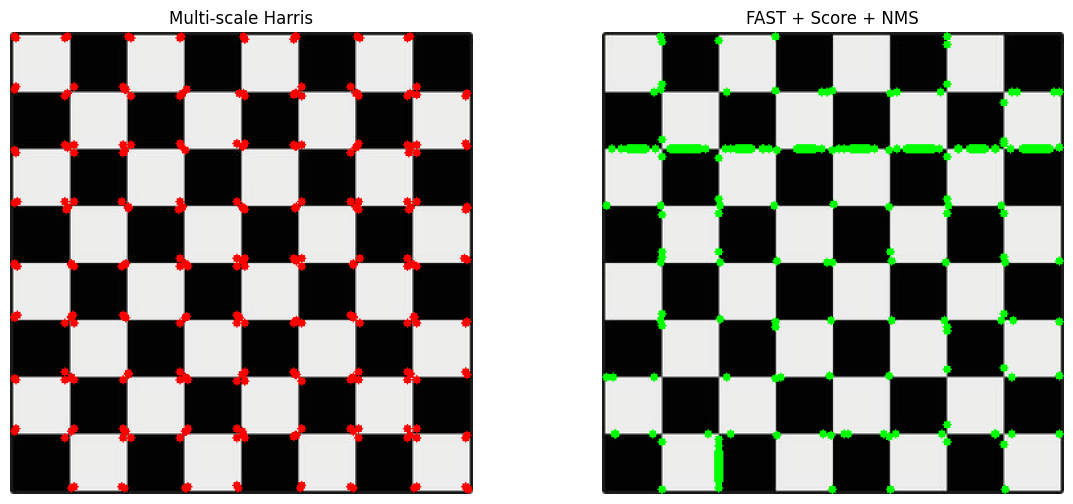

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import sobel, gaussian_filter, uniform_filter, maximum_filter

# =============================================================================
#                           UTILITY FUNCTIONS
# =============================================================================

def non_max_suppression(score_map, radius):
    """Radius-based non-maximum suppression"""
    max_map = maximum_filter(score_map, size=2*radius + 1)
    return (score_map == max_map) & (score_map > 0)


def subpixel_refinement(R, y, x):
    """
    Sub-pixel refinement using 2D quadratic fit
    """
    if y <= 0 or x <= 0 or y >= R.shape[0]-1 or x >= R.shape[1]-1:
        return y, x

    dx = (R[y, x+1] - R[y, x-1]) / 2
    dy = (R[y+1, x] - R[y-1, x]) / 2
    dxx = R[y, x+1] - 2*R[y, x] + R[y, x-1]
    dyy = R[y+1, x] - 2*R[y, x] + R[y-1, x]

    if dxx != 0:
        x = x - dx / dxx
    if dyy != 0:
        y = y - dy / dyy

    return y, x


# =============================================================================
#                       MULTI-SCALE HARRIS CORNER
# =============================================================================

def harris_multiscale(
    gray,
    sigmas=(1.0, 2.0, 4.0),
    k=0.04,
    window_size=5,
    nms_radius=4,
    percentile=99,
    top_n=300
):
    corners = []

    for sigma in sigmas:
        Ix = gaussian_filter(sobel(gray, axis=1), sigma)
        Iy = gaussian_filter(sobel(gray, axis=0), sigma)

        Ixx = Ix * Ix
        Iyy = Iy * Iy
        Ixy = Ix * Iy

        Sxx = uniform_filter(Ixx, window_size)
        Syy = uniform_filter(Iyy, window_size)
        Sxy = uniform_filter(Ixy, window_size)

        det = Sxx * Syy - Sxy ** 2
        trace = Sxx + Syy
        R = det - k * trace ** 2

        thresh = np.percentile(R, percentile)
        R[R < thresh] = 0

        nms_mask = non_max_suppression(R, nms_radius)
        ys, xs = np.where(nms_mask)

        for y, x in zip(ys, xs):
            ry, rx = subpixel_refinement(R, y, x)
            corners.append((ry, rx, R[y, x], sigma))

    corners.sort(key=lambda x: x[2], reverse=True)
    return corners[:top_n]


# =============================================================================
#                           FAST WITH SCORE + NMS
# =============================================================================

def fast_with_score(gray, threshold=25, n=12, nms_radius=3, top_n=300):
    h, w = gray.shape
    scores = np.zeros_like(gray, dtype=np.float32)

    circle = [
        (0,3),(1,3),(2,2),(3,1),(3,0),(3,-1),(2,-2),(1,-3),
        (0,-3),(-1,-3),(-2,-2),(-3,-1),(-3,0),(-3,1),(-2,2),(-1,3)
    ]

    for y in range(3, h-3):
        for x in range(3, w-3):
            center = int(gray[y, x])
            diffs = [abs(int(gray[y+dy, x+dx]) - center) for dx, dy in circle]
            diffs = np.array(diffs)

            if np.sum(diffs > threshold) >= n:
                scores[y, x] = np.sum(diffs)

    nms_mask = non_max_suppression(scores, nms_radius)
    ys, xs = np.where(nms_mask)

    pts = [(y, x, scores[y, x]) for y, x in zip(ys, xs)]
    pts.sort(key=lambda x: x[2], reverse=True)

    return pts[:top_n]


# =============================================================================
#                               MAIN
# =============================================================================

def main():
    # 🔴 Colab image path
    img = cv2.imread("/chessboard.jpg")
    if img is None:
        print("❌ Image not found")
        return

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)
    total_pixels = gray.shape[0] * gray.shape[1]

    # Run detectors
    harris_pts = harris_multiscale(gray)
    fast_pts = fast_with_score(gray.astype(np.uint8))

    # Count corners
    harris_count = len(harris_pts)
    fast_count = len(fast_pts)

    # Percentage score
    harris_score = (harris_count / total_pixels) * 100
    fast_score = (fast_count / total_pixels) * 100

    # -----------------------------
    # RESULT TABLE
    # -----------------------------
    df = pd.DataFrame({
        "Method": ["Harris (Multi-scale)", "FAST"],
        "Corners Detected": [harris_count, fast_count],
        "Score (%)": [round(harris_score, 5), round(fast_score, 5)]
    })

    print("\n📊 CORNER DETECTION SCORE TABLE\n")
    print(df)

    # -----------------------------
    # VISUALIZATION
    # -----------------------------
    harris_img = img.copy()
    for y, x, _, _ in harris_pts:
        cv2.circle(harris_img, (int(x), int(y)), 3, (0,0,255), -1)

    fast_img = img.copy()
    for y, x, _ in fast_pts:
        cv2.circle(fast_img, (x, y), 3, (0,255,0), -1)

    plt.figure(figsize=(14,6))

    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(harris_img, cv2.COLOR_BGR2RGB))
    plt.title("Multi-scale Harris")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(fast_img, cv2.COLOR_BGR2RGB))
    plt.title("FAST + Score + NMS")
    plt.axis("off")

    plt.show()


if __name__ == "__main__":
    main()



📊 CORNER DETECTION SCORE TABLE

   Method  Corners Detected  Score (%)
0  Harris               250     0.0482
1    FAST               250     0.0482


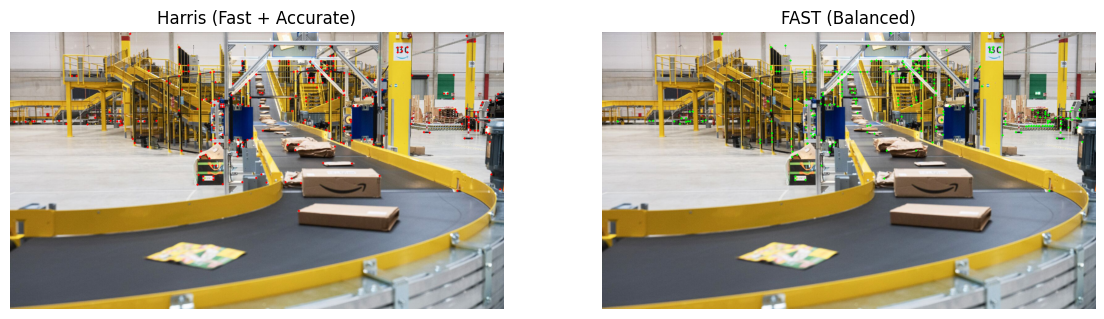

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import sobel, gaussian_filter, uniform_filter, maximum_filter

# =============================================================================
# UTILITY: FAST NMS (VECTORISED & FAST)
# =============================================================================
def non_max_suppression(score_map, radius):
    max_map = maximum_filter(score_map, size=2*radius + 1)
    return (score_map == max_map) & (score_map > 0)


# =============================================================================
# HARRIS CORNER DETECTOR (FAST + ACCURATE)
# =============================================================================
def harris_fast(
    gray,
    sigmas=(1.0, 2.0),   # reduced but still multi-scale
    k=0.04,
    window_size=5,
    nms_radius=3,
    percentile=99,
    top_n=250
):
    all_corners = []

    for sigma in sigmas:
        # Smooth first (stability)
        smooth = gaussian_filter(gray, sigma)

        Ix = sobel(smooth, axis=1)
        Iy = sobel(smooth, axis=0)

        Ixx = Ix * Ix
        Iyy = Iy * Iy
        Ixy = Ix * Iy

        Sxx = uniform_filter(Ixx, window_size)
        Syy = uniform_filter(Iyy, window_size)
        Sxy = uniform_filter(Ixy, window_size)

        R = (Sxx * Syy - Sxy**2) - k * (Sxx + Syy)**2

        thresh = np.percentile(R, percentile)
        R[R < thresh] = 0

        nms = non_max_suppression(R, nms_radius)
        ys, xs = np.where(nms)

        for y, x in zip(ys, xs):
            all_corners.append((y, x, R[y, x]))

    all_corners.sort(key=lambda x: x[2], reverse=True)
    return all_corners[:top_n]


# =============================================================================
# FAST CORNER DETECTOR (FAST + BETTER ACCURACY)
# =============================================================================
def fast_balanced(gray, threshold=25, n=9, nms_radius=3, top_n=250):
    h, w = gray.shape
    score_map = np.zeros_like(gray, dtype=np.float32)

    circle = np.array([
        (0,3),(1,3),(2,2),(3,1),(3,0),(3,-1),(2,-2),(1,-3),
        (0,-3),(-1,-3),(-2,-2),(-3,-1),(-3,0),(-3,1),(-2,2),(-1,3)
    ])

    for y in range(3, h-3):
        for x in range(3, w-3):
            c = int(gray[y, x])
            diffs = np.abs(gray[y + circle[:,1], x + circle[:,0]].astype(int) - c)

            if np.sum(diffs > threshold) >= n:
                score_map[y, x] = np.sum(diffs)

    nms = non_max_suppression(score_map, nms_radius)
    ys, xs = np.where(nms)

    pts = [(y, x, score_map[y, x]) for y, x in zip(ys, xs)]
    pts.sort(key=lambda x: x[2], reverse=True)

    return pts[:top_n]


# =============================================================================
# MAIN
# =============================================================================
def main():
    img = cv2.imread("/i4.jpg")
    if img is None:
        print("❌ Image not found")
        return

    # 🔑 SPEED BOOST (very important)
    img = cv2.resize(img, None, fx=0.6, fy=0.6)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)
    total_pixels = gray.shape[0] * gray.shape[1]

    # Run detectors
    harris_pts = harris_fast(gray)
    fast_pts = fast_balanced(gray.astype(np.uint8))

    # Counts
    h_count = len(harris_pts)
    f_count = len(fast_pts)

    # Percentage score
    h_score = (h_count / total_pixels) * 100
    f_score = (f_count / total_pixels) * 100

    # ---------------- TABLE ----------------
    df = pd.DataFrame({
        "Method": ["Harris", "FAST"],
        "Corners Detected": [h_count, f_count],
        "Score (%)": [round(h_score, 4), round(f_score, 4)]
    })

    print("\n📊 CORNER DETECTION SCORE TABLE\n")
    print(df)

    # ---------------- VISUALIZATION ----------------
    h_img = img.copy()
    for y, x, _ in harris_pts:
        cv2.circle(h_img, (x, y), 2, (0,0,255), -1)

    f_img = img.copy()
    for y, x, _ in fast_pts:
        cv2.circle(f_img, (x, y), 2, (0,255,0), -1)

    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(h_img, cv2.COLOR_BGR2RGB))
    plt.title("Harris (Fast + Accurate)")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(f_img, cv2.COLOR_BGR2RGB))
    plt.title("FAST (Balanced)")
    plt.axis("off")
    plt.show()


if __name__ == "__main__":
    main()
